# CS 109A - Intro to Data Science: Project (WIP)
## Predicting Loan Outcomes
## Group: Andrew Greene and David Modjeska
### Harvard University, Fall 2016

In [364]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier as Boost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from scipy.io import mmread

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

In [365]:
### specify processed data files to generate - full/partial, partial %, and train/test
### Note: this cell is the same in both notebooks

# load and clean full dataset?
load_full = False

# if not loading and cleaning full dataset, what sample percentage?
sample_percent = 10

if load_full:
    pct_str = ""
else: # not load_full
    pct_str = str(sample_percent) + "_pct"
    
# use training or testing data to generate minor files?
minor_use_train = True
if minor_use_train:
    mode_str = "train"
else: # not minor_use_train
    mode_str = "test"
    
### set intermediate file names
dir_str = "./intermediate_files/"

processed_data_train_file = dir_str + "processed_data_" + "train" + pct_str + ".json"
processed_data_test_file = dir_str + "processed_data_" + "test" + pct_str + ".json"

nlp_data_file = dir_str + "nlp_data_" + mode_str + pct_str + ".json"
term_freqs_file = dir_str + "term_freqs_" + mode_str + pct_str + ".mtx"
diff_terms_file = dir_str + "diff_terms_" + mode_str + pct_str + ".json"

In [366]:
### load processed data
data = pd.read_json(processed_data_train_file)
data_nlp = pd.read_json(nlp_data_train_file)
desc_matrix_coo = mmread(term_freqs_train_file)
desc_matrix = sp.sparse.csr_matrix(desc_matrix_coo)
count_cols_df = pd.read_json(diff_terms_train_file)

count_cols_bool = count_cols_df.values > 0.0

In [367]:
x = data.drop('loan_status', 1)
y = data['loan_status']

x_nlp = data_nlp.drop('loan_status', 1)
y_nlp = data_nlp['loan_status']

## Step 2: Explore Data

In [368]:
image_counter = 0

In [369]:
def good_bad_quantile_plot(data, column):
    global image_counter
    
    col_data = data[column]
    nulls = pd.isnull(col_data)
    col_data = col_data[~nulls]
    #if col_data.dtype == '<M8[ns]':
    #    col_data = col_data.dt.strftime('%Y-%m')
    
    defaults = data['loan_status'] == True  # for now TODO

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # 45-degree line
    ax.plot(
        [min(col_data), max(col_data)],
        [min(col_data), max(col_data)],
        c='k'
    )
    # Actual qq plot
    ax.plot(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.005, .005))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.0005, .005))),
        c='r'
    )
    ax.scatter(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        c='r'
    )
    
    ax.set_title("QQ plot for " + column)
    ax.set_xlabel('Good loans')
    ax.set_ylabel('Bad loans')
    
    plt.show()
    
    fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
    image_counter += 1

In [370]:
# print dataset shape, and widen pandas dataframe display
n, p = data.shape
pd.set_option('display.max_columns', p)

print
print "The shape of the data is", data.shape
print


The shape of the data is (17761, 31)



In [371]:
# display top rows of data set
print
data.head()

,address_state,annual_income,cpi,delinq_2_yrs,desc_len,description,dti,earliest_credit,employ_length,employ_title,gdp,home_owner,index,initial_list_status,inquiry_6_mos,installment,interest_rate,ipr,issue_date,loan_amount,loan_purpose,loan_status,loan_subgrade,loan_term,months_since_last_record,open_accounts,revol_util,rir,total_accounts,unemploy,verif_status
1,TX,"89,898",0,1,92,Borrower added on _number_/_number_/_number_...,0,1993-10-01,10,Calibrator,1,RENT,51951,w,3,272,14,0,Dec-2013,8000,credit_card,False,10,36,nan,14,0,0,25,0,nan
100,NY,"55,405",0,0,71,Borrower added on _number_/_number_/_number_...,0,2001-01-01,10,GRANT ASSISTANT,1,RENT,62680,f,2,745,26,0,Nov-2013,24925,debt_consolidation,True,35,60,nan,9,0,0,27,0,nan
10000,TX,"96,000",0,0,nan,None,0,2003-06-01,5,Director of Training,1,OWN,731465,f,1,"1,286",19,0,Jun-2015,35000,debt_consolidation,False,25,36,nan,12,0,0,18,0,nan
10002,TX,"112,000",0,0,nan,None,0,2005-01-01,2,investigator,1,MORTGAGE,772599,w,0,395,17,0,Apr-2015,15900,debt_consolidation,False,20,60,nan,14,0,0,35,0,nan
10004,DC,"65,000",0,0,nan,None,0,2000-08-01,3,Data Governance Manager,1,RENT,747349,f,3,450,20,0,May-2015,17000,debt_consolidation,False,25,60,nan,19,0,0,20,0,nan


In [372]:
# summarize data set
print
data.describe()

,annual_income,cpi,delinq_2_yrs,desc_len,dti,gdp,index,inquiry_6_mos,installment,interest_rate,ipr,loan_amount,loan_subgrade,loan_term,months_since_last_record,open_accounts,revol_util,rir,total_accounts,unemploy,verif_status
count,"17,761","17,761","17,761","6,178","17,761","17,761","17,761","17,761","17,761","17,761","17,761","17,761","17,761","17,761","2,174","17,761","17,761","17,761","17,761","17,761",0
mean,"72,333",0,0,290,0,1,"255,088",1,418,14,0,"13,565",14,41,77,11,0,0,25,0,nan
std,"59,471",0,1,312,0,0,"217,691",1,245,4,0,"8,133",7,10,29,5,0,0,12,0,nan
min,"4,800",0,0,1,0,1,0,0,22,5,0,"1,000",5,36,0,1,0,0,3,0,nan
25%,"45,000",0,0,nan,0,1,"100,498",0,240,11,0,"7,200",10,36,nan,7,0,0,16,0,nan
50%,"62,000",0,0,nan,0,1,"197,176",1,366,14,0,"12,000",15,36,nan,10,0,0,23,0,nan
75%,"86,547",0,0,nan,0,1,"363,917",1,547,16,0,"18,400",20,36,nan,13,0,0,32,0,nan
max,"5,000,000",0,2,"4,459",0,1,"887,371",3,"1,408",28,0,"35,000",35,60,119,49,0,0,91,0,nan


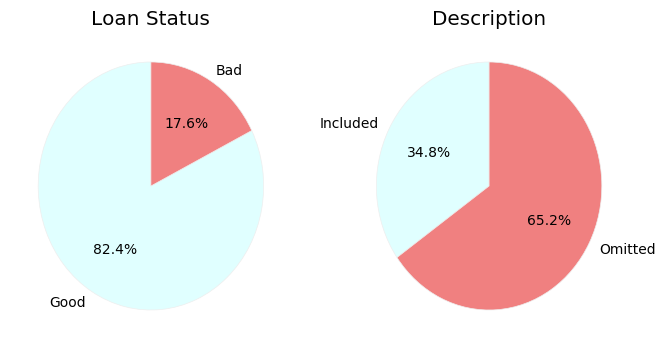

In [373]:
### plot description-related variables as pie charts
n, p = data.shape
fig = plt.figure(figsize = (8, 4))

# loan status
num_good = (data["loan_status"] == False).sum()
num_bad = n - num_good
pie_1 = fig.add_subplot(121)
pie_1.pie([num_good, num_bad], 
          labels = ["Good", "Bad"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_1.set_title("Loan Status")

# description included
num_include = (data["description"].notnull()).sum()
num_omit = n - num_include
pie_3 = fig.add_subplot(122)
pie_3.pie([num_include, num_omit], 
          labels = ["Included", "Omitted"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_3.set_title("Description")

plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

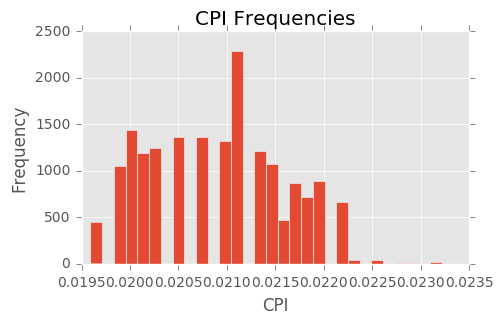

In [374]:
# plot histogram of CPI
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['cpi'], bins = 30)
ax.set_title("CPI Frequencies")
ax.set_xlabel("CPI")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

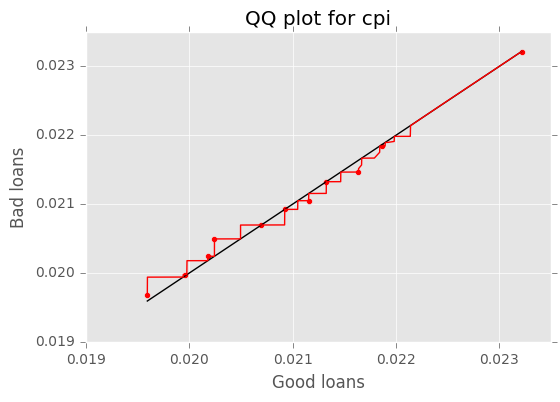

In [375]:
good_bad_quantile_plot(data, 'cpi')

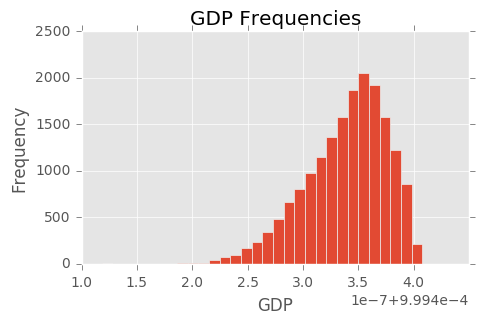

In [376]:
# plot histogram of GDP
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['gdp'] / 1000.0, bins = 30)
ax.set_title("GDP Frequencies")
ax.set_xlabel("GDP")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

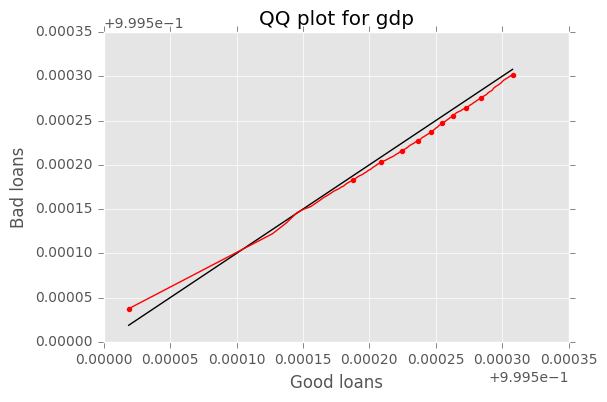

In [377]:
good_bad_quantile_plot(data, 'gdp')

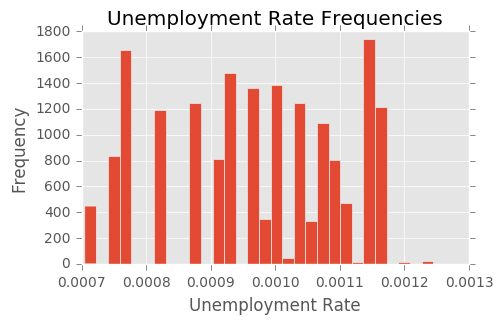

In [378]:
# plot histogram of unemployment rate
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data['unemploy'], bins = 30)
ax.set_title("Unemployment Rate Frequencies")
ax.set_xlabel("Unemployment Rate")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

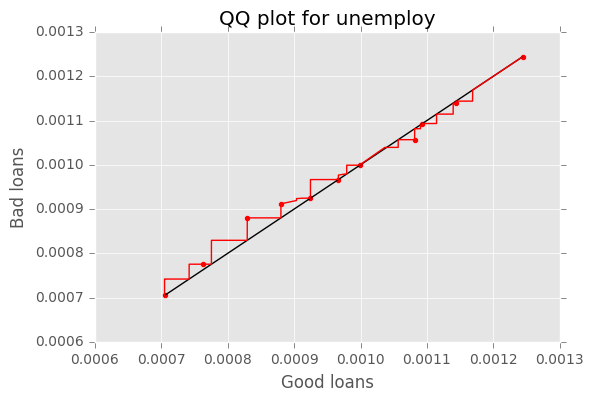

In [379]:
good_bad_quantile_plot(data, 'unemploy')

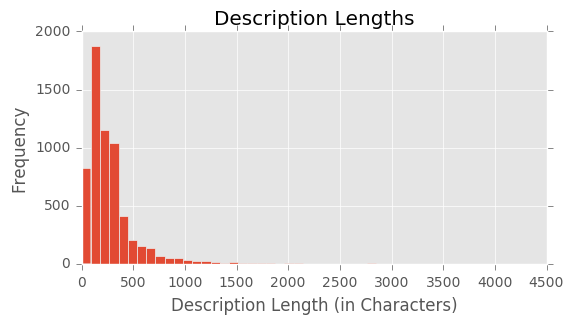

In [380]:
# visualize description lengths in characters
fig = plt.figure(figsize = (6, 3))

description_flags = data["description"].notnull()
description_lengths = data['desc_len'][description_flags]

ax1 = fig.add_subplot(111)
ax1.hist(description_lengths, bins = 50)
ax1.set_title("Description Lengths")
ax1.set_xlabel("Description Length (in Characters)")
ax1.set_ylabel("Frequency")

plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

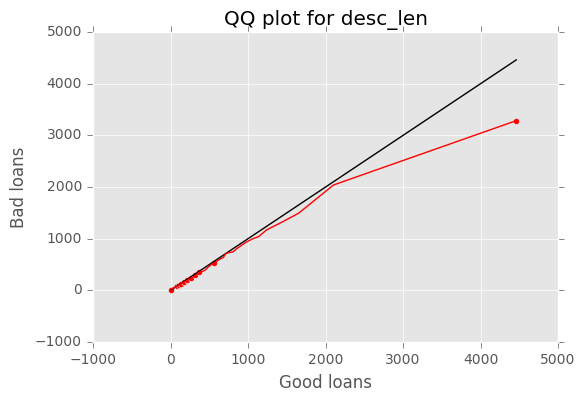

In [381]:
data_desc = data[description_flags]
good_bad_quantile_plot(data_desc, 'desc_len')

In [382]:
description_lengths_df = pd.DataFrame(description_lengths)
description_lengths_df.columns = ["description_length_chars"]
description_lengths_df.describe()

,description_length_chars
count,"6,178"
mean,290
std,312
min,1
25%,119
50%,207
75%,342
max,"4,459"


In [383]:
# Are descriptions correlated with inclusion of descriptions?
data_corr = pd.concat((data["loan_status"], description_flags), axis = 1)
corr_matrix = np.corrcoef(data_corr.T)

print
print "Loan status is not correlated with the inclusion of descriptions:\n"
print corr_matrix
print


Loan status is not correlated with the inclusion of descriptions:

[[ 1.        -0.0129507]
 [-0.0129507  1.       ]]



### Text Analysis

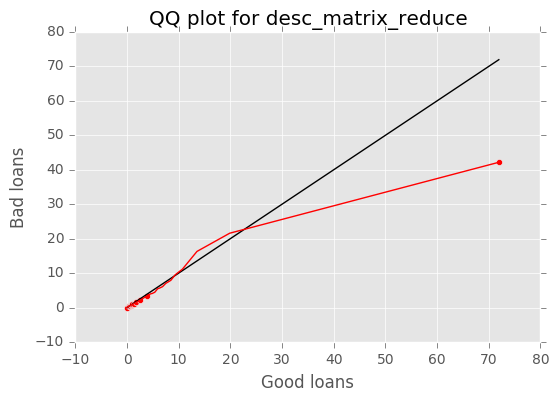

In [384]:
good_bad_quantile_plot(data_nlp, 'desc_matrix_reduce')

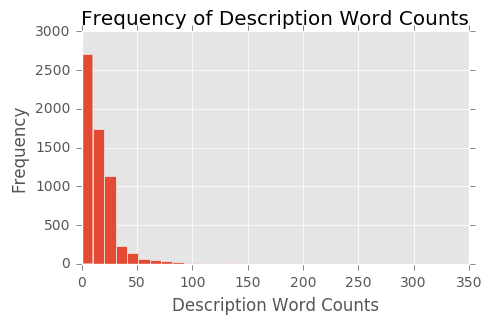

In [385]:
# plot histogram of word counts by description
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['desc_word_count'].values, bins = 30)
ax.set_title("Frequency of Description Word Counts")
ax.set_xlabel("Description Word Counts")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

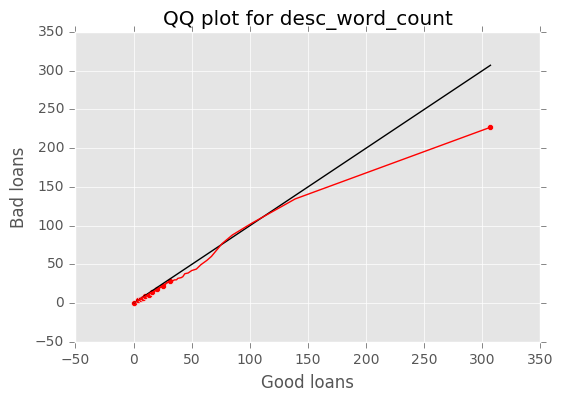

In [386]:
good_bad_quantile_plot(data_nlp, "desc_word_count")

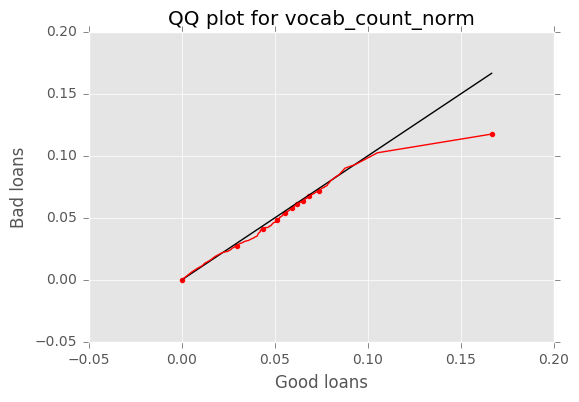

In [387]:
good_bad_quantile_plot(data_nlp, "vocab_count_norm")

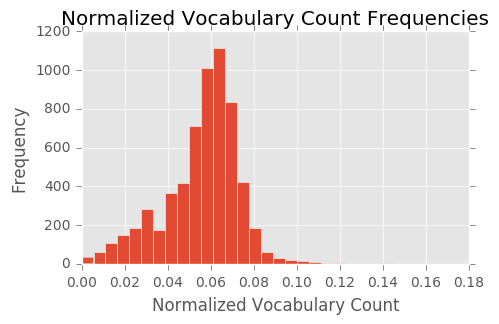

In [388]:
# plot histogram of vocabulary richness
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['vocab_count_norm'], bins = 30)
ax.set_title("Normalized Vocabulary Count Frequencies")
ax.set_xlabel("Normalized Vocabulary Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

In [389]:
print desc_matrix.shape

(6210, 4752)


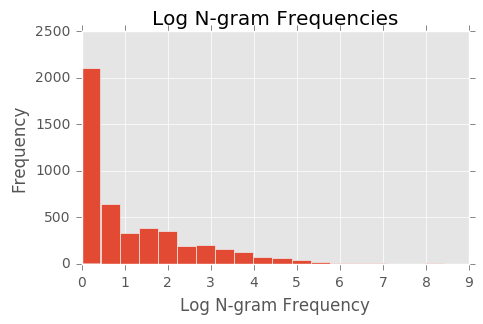

In [390]:
ngram_counts = np.log(desc_matrix.sum(axis = 0))

# plot histogram of n-gram frequency
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(ngram_counts.transpose(), bins = 20)
ax.set_title("Log N-gram Frequencies")
ax.set_xlabel("Log N-gram Frequency")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

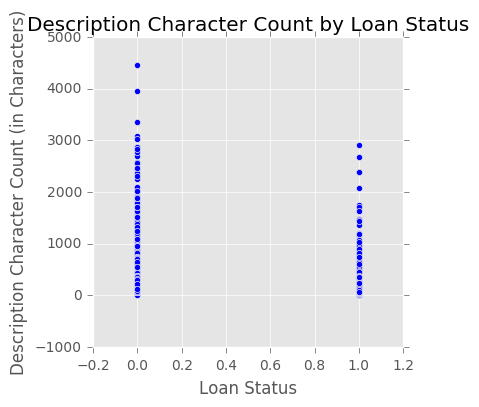

In [391]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_len'])
ax1.set_title("Description Character Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Character Count (in Characters)")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

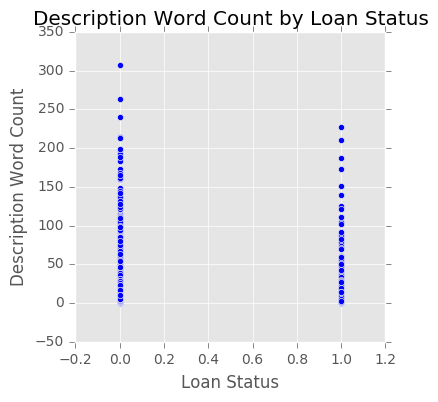

In [392]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_word_count'])
ax1.set_title("Description Word Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Word Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

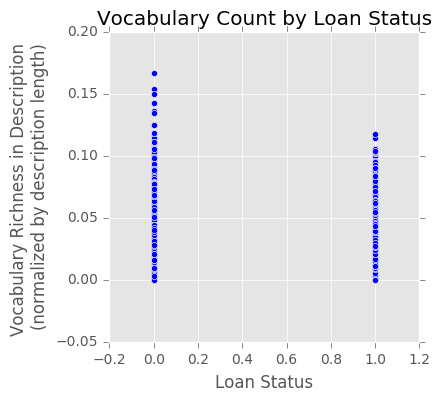

In [393]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['vocab_count_norm'])
ax1.set_title("Vocabulary Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Vocabulary Richness in Description \n(normalized by description length)")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

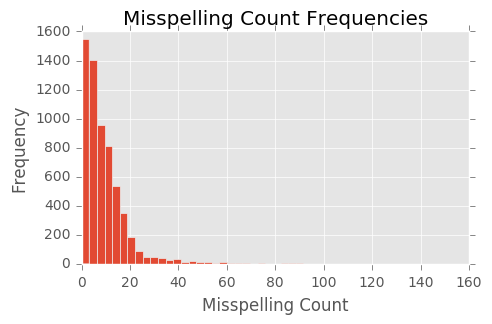

In [394]:
# plot histogram of misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count'], bins = 50)
ax.set_title("Misspelling Count Frequencies")
ax.set_xlabel("Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

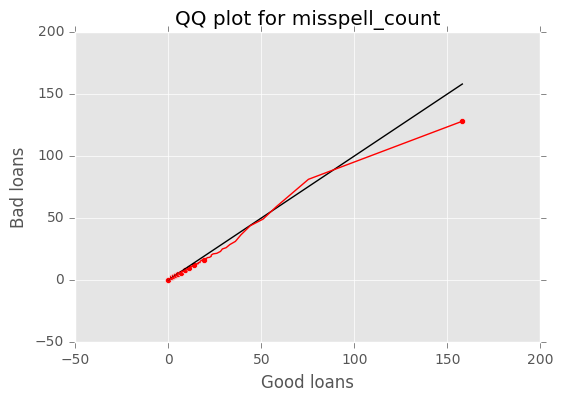

In [395]:
good_bad_quantile_plot(data_nlp, "misspell_count")

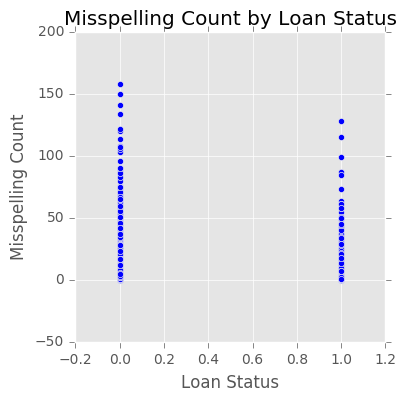

In [396]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count'])
ax1.set_title("Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Misspelling Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

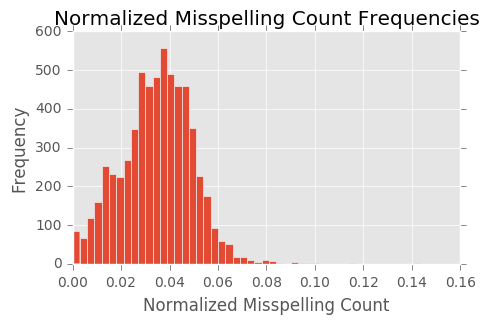

In [397]:
# plot histogram of normalized misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count_norm'], bins = 50)
ax.set_title("Normalized Misspelling Count Frequencies")
ax.set_xlabel("Normalized Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

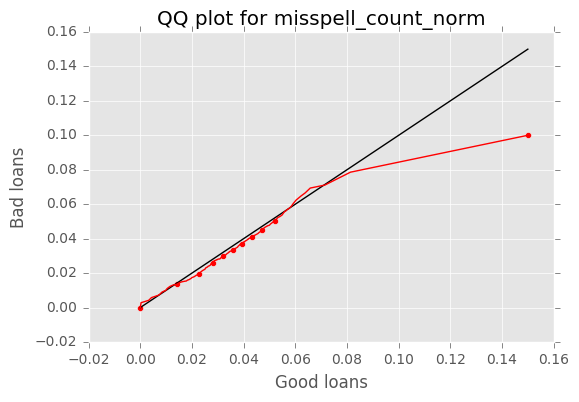

In [398]:
good_bad_quantile_plot(data_nlp, "misspell_count_norm")

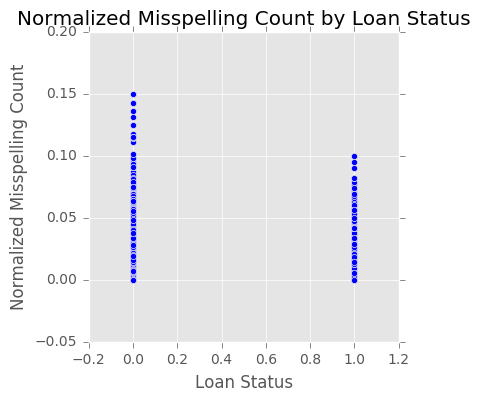

In [399]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count_norm'])
ax1.set_title("Normalized Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Normalized Misspelling Count")
plt.show()

fig.savefig('Images/img_' + str(image_counter) + '.png', bbox_inches='tight')
image_counter += 1

### Plot NLP Features

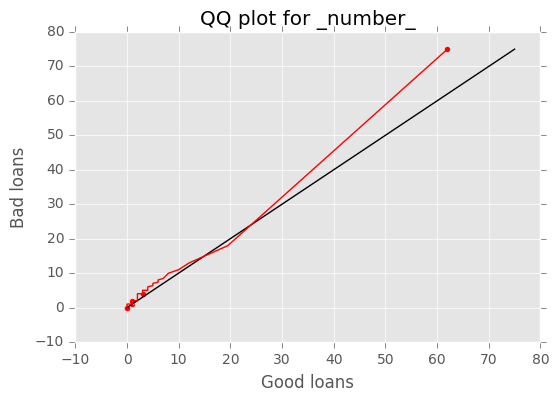

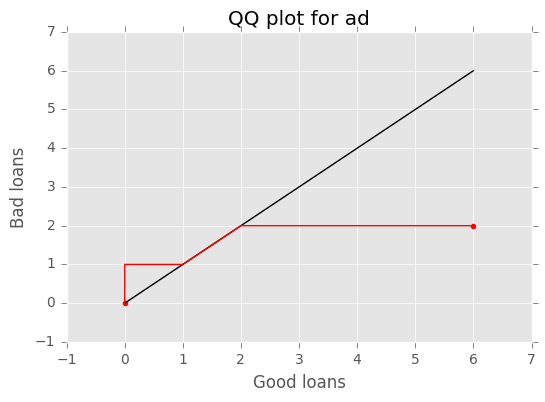

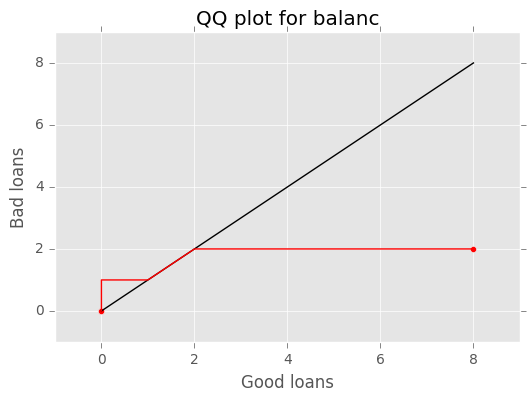

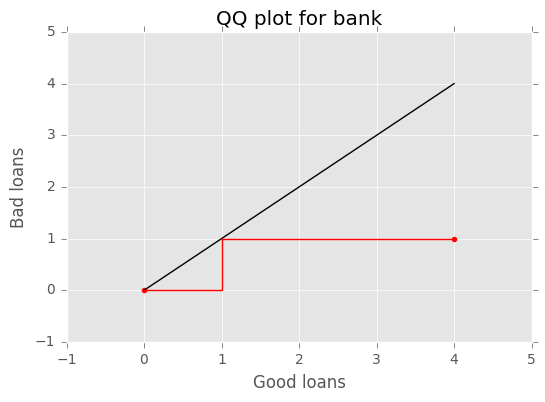

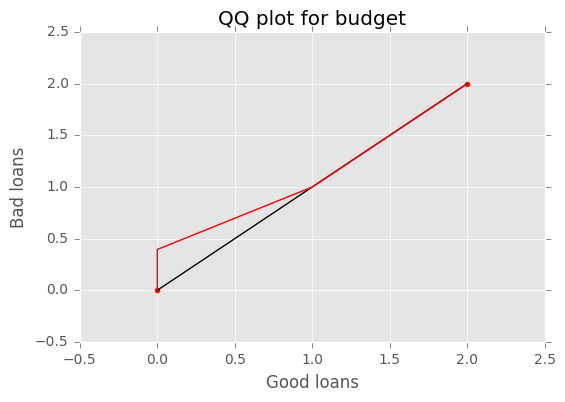

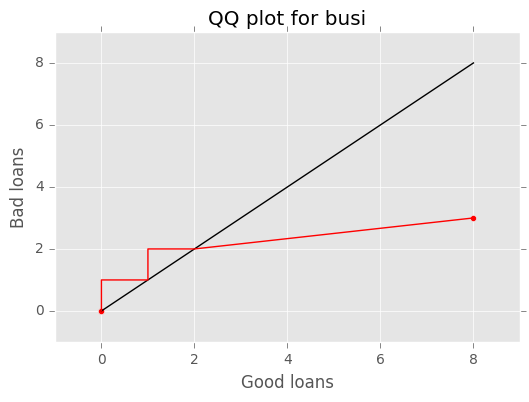

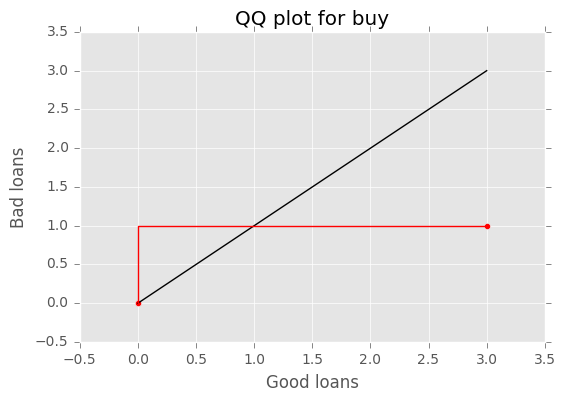

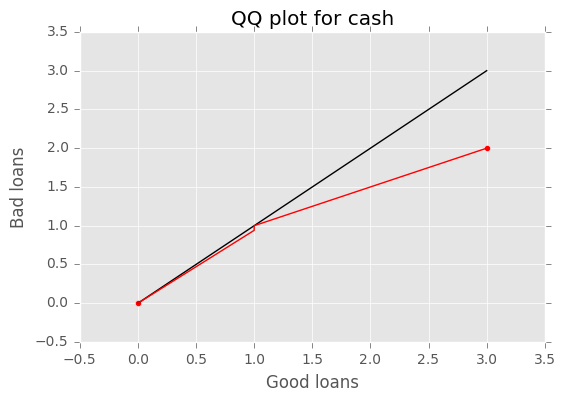

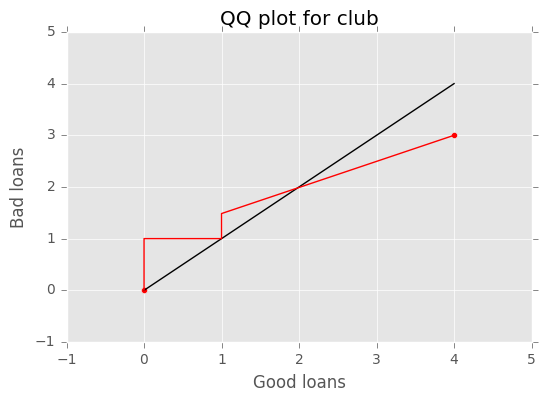

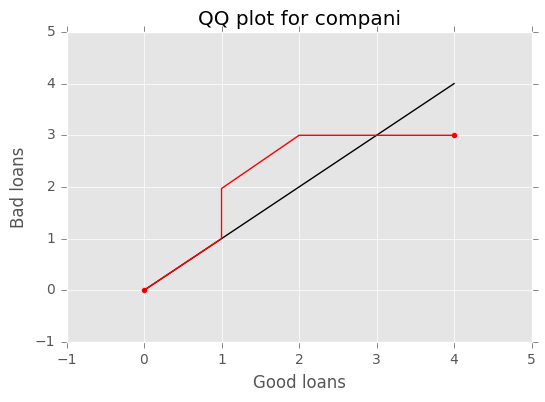

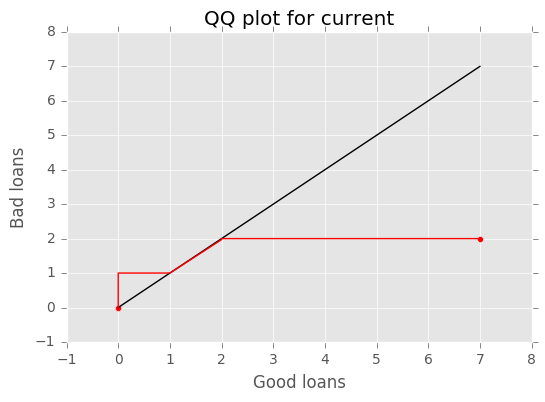

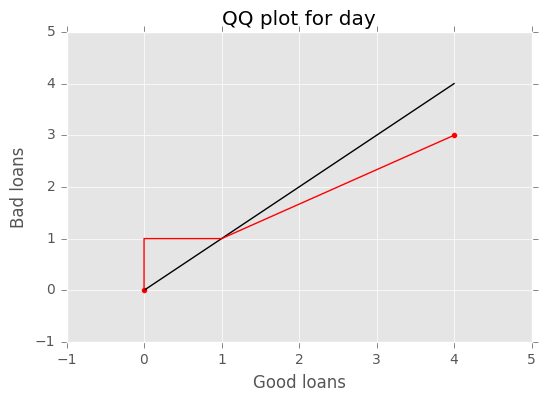

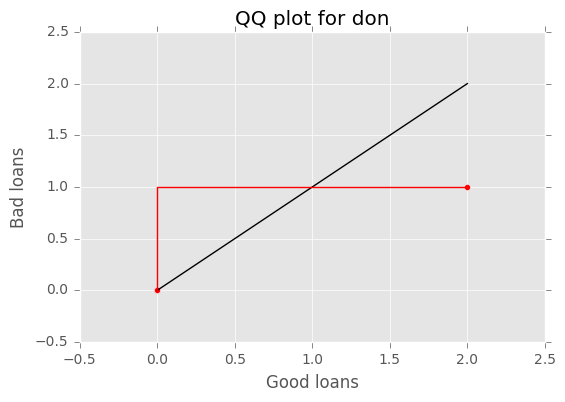

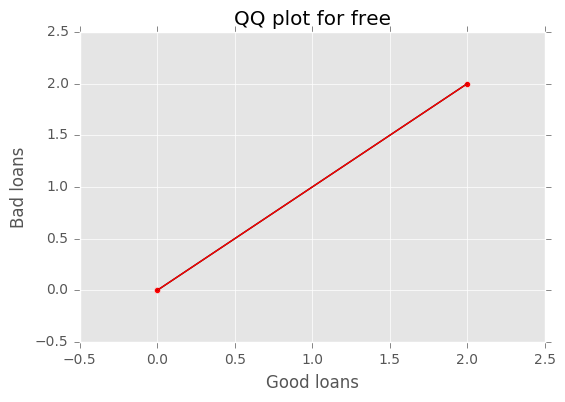

In [400]:
count_cols_qq_data = pd.concat((data_nlp['loan_status'], count_cols_df), axis = 1)
for index in range(1, count_cols_bool.shape[1] / 2):
    good_bad_quantile_plot(count_cols_qq_data, count_cols_qq_data.columns[index])

## Step 3: Model Data

In [401]:
# function to calculate expected revenue
def expected_revenue(data):
    revenue = (data['installment'] * data['loan_term']) - data['loan_amount']
    return revenue

### Baseline Models

In [402]:
# function to compute accuracy of given model on full test set, on class 0, and on class 1
score = lambda model, x_test, y_test: \
        pd.Series([model.score(x_test, y_test), 
                    model.score(x_test[y_test == 0], y_test[y_test == 0]),
                    model.score(x_test[y_test == 1], y_test[y_test == 1])],
                    index = ['Overall Accuracy', 'Accuracy on Class 0', 'Accuracy on Class 1'])

In [403]:
# function to compute revenue of given model on full test set, on class 0, and on class 1
revenue = lambda model, x, y: \
        pd.Series([model.revenue(x, y), 
                    model.revenue(x[y == 0], y[y == 0]),
                    model.revenue(x[y == 1], y[y == 1])],
                    index = ['Overall Revenue', 'Revenue for Class 0', 'Revenue for Class 1'])

In [404]:
# model that labels everything 1
class Pos_model(object):
    
    def predict(self, x):
        return np.array([1] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
    def revenue(self, x, y):
        y_pred = self.predict(x)
        revenue = np.zeros(x.shape[0])
        revenue[y_pred == 0] = expected_revenue(x[y_pred == 0])
        return revenue.sum()

In [405]:
# model that labels everything 0
class Neg_model(object):
    
    def predict(self, x):
        return np.array([0] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
    def revenue(self, x, y):
        y_pred = self.predict(x)
        revenue = np.zeros(x.shape[0])
        revenue[y_pred == 0] = expected_revenue(x[y_pred == 0])
        return revenue.sum()

In [406]:
# model that randomly labels things
class Random_model(object):
    
    def predict(self, x):
        return np.random.randint(0, 2, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)
    
    def revenue(self, x, y):
        y_pred = self.predict(x)
        revenue = np.zeros(x.shape[0])
        revenue[y_pred == 0] = expected_revenue(x[y_pred == 0])
        return revenue.sum()

In [407]:
### score using baseline models

pos_model = Pos_model()
pos_model_scores = score(pos_model, x, y)
pos_model_revenues = revenue(pos_model, x, y)

neg_model = Neg_model()
neg_model_scores = score(neg_model, x, y)
neg_model_revenues = revenue(neg_model, x, y)

random_model = Random_model()
random_model_scores = score(random_model, x, y)
random_model_revenues = revenue(random_model, x, y)

In [408]:
# print scores
pd.options.display.float_format = '{:,.2f}'.format
score_df = pd.DataFrame({'Positive Model': pos_model_scores,
                         'Negative Model': neg_model_scores,
                         'Random Model': random_model_scores})
print
score_df

,Negative Model,Positive Model,Random Model
Overall Accuracy,0.82,0.18,0.50
Accuracy on Class 0,1.00,0.00,0.50
Accuracy on Class 1,0.00,1.00,0.48


In [409]:
# print revenues
pd.options.display.float_format = '{:,.0f}'.format
revenue_df = pd.DataFrame({'Positive Model': pos_model_revenues,
                         'Negative Model': neg_model_revenues,
                         'Random Model': random_model_revenues})
print
revenue_df

,Negative Model,Positive Model,Random Model
Overall Revenue,"73,053,489",0,"36,482,586"
Revenue for Class 0,"55,496,689",0,"27,470,294"
Revenue for Class 1,"17,556,801",0,"8,534,970"


### Other Models

In [410]:
# define model types
log_reg = 2
lda = 3
qda = 4
knn = 5
rf = 6
boost = 7
svm = 8

In [411]:
# function to return name of model type
def get_model_name(model_type):
    if model_type == log_reg:
        model_name = "logistic regression"
    elif model_type == lda:
        model_name = "LDA"
    elif model_type == qda:
        model_name = "QDA"
    elif model_type == knn:
        model_name = "KNN"
    elif model_type == rf:
        model_name = "random forests"
    elif model_type == boost:
        model_name = "boost"
    elif model_type == svm:
        model_name = "SVM"
    else:
        model_name = ""
        
    return model_name

In [412]:
# function to return unfitted model of given type
def get_model_instance(model_type, y):
    default_ratio = (y == True).sum() / float(len(y))
    priors = (default_ratio, 1.0 - default_ratio)
    
    if model_type == log_reg:
         model_instance = Log_Reg(C = 10 ** -4, class_weight = 'balanced',
                                 penalty = 'l2', solver = 'liblinear', fit_intercept = True)
    elif model_type == lda:
        model_instance = LDA(priors = priors)
    elif model_type == qda:
        model_instance = QDA(reg_param = 0.0001)
    elif model_type == knn:
        model_instance = KNN(n_neighbors = 5)
    elif model_type == rf:
        model_instance = RFC(n_estimators = 10, class_weight = 'balanced',
                            max_features = 'auto', max_depth = 20)
    elif model_type == boost:
        model_instance = Boost(n_estimators = 100, learning_rate = 0.4)
    elif model_type == svm:
        model_instance = SVC(C = 100, kernel = 'poly', degree = 2, class_weight = 'balanced',
                            shrinking = True)
    else:
        model_instance = None
        
    return model_instance

In [413]:
# function to fit and score one model of given type
def fit_and_score_one_model(x, y, model_type):
    n = x.shape[0]

    train_score_accum = 0
    test_score_accum = 0
    cm_accum = np.zeros((2, 2))
    f1_accum = 0
    num_iters = 3
    for i in range(num_iters):
        mask = np.random.rand(n) < 0.8
     
        x_train = x[mask, :]
        x_test = x[~mask, :]
        
        y_train = y.iloc[mask]
        y_test = y.iloc[~mask]
  
        model = get_model_instance(model_type, y_train)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_test)
        cm_accum += confusion_matrix(y_test, y_predict)
        train_score_accum += model.score(x_train, y_train)
        test_score_accum += model.score(x_test, y_test)
        f1_accum += f1_score(y_test, y_predict, pos_label = 1)

    # calculate accuracy
    train_score = train_score_accum / float(num_iters)
    test_score = test_score_accum / float(num_iters)
    f1_result = f1_accum / float(num_iters)

    # compute confusion matrix
    cm = cm_accum / float(num_iters)
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)
    
    # output results
    model_name = get_model_name(model_type)
    print "Accuracy with " + model_name + ":"
    print "\tTraining:", round(train_score, 4)
    print "\tTesting:", round(test_score, 4)
    print
    print "Confusion Matrix:"
    display(cm_df)
    print "F1 score = ", f1_result

### NLP

In [414]:
# KNN 
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], knn)

In [415]:
# logistic regression
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.5422
	Testing: 0.5173

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,545,482
1,Actual_good,113,94


F1 score =  0.239338928796


In [416]:
# logistic regression 
fit_and_score_one_model(data_nlp[['misspell_count', 'desc_len']].values, 
                        data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.8417
	Testing: 0.7009

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,827,207
1,Actual_good,168,52


F1 score =  0.215294312551


In [417]:
# nlp_plus = np.concatenate((count_cols_bool.toarray(), data_nlp[['loan_amount']]), axis = 1)
# fit_and_score_one_model(nlp_plus, data_nlp['loan_status'], log_reg)

In [418]:
# LDA
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], lda)

Accuracy with LDA:
	Training: 0.1718
	Testing: 0.1702

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,0,"1,042"
1,Actual_good,0,214


F1 score =  0.290859795863


In [419]:
# # use description column with QDA to predict defaults and score accuracy
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], qda)

Accuracy with QDA:
	Training: 0.789
	Testing: 0.7595

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,932,105
1,Actual_good,198,23


F1 score =  0.131800223835


In [420]:
# random forests 
fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.6897
	Testing: 0.6037

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,698,339
1,Actual_good,157,62


F1 score =  0.189791270873


In [421]:
# SVM
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], svm)

In [422]:
# boosting
# fit_and_score_one_model(count_cols_bool, data_nlp['loan_status'], boost)

In [423]:
fit_and_score_one_model(desc_matrix, data_nlp['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.7233
	Testing: 0.7096

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,853,206
1,Actual_good,162,45


F1 score =  0.189713881831


In [424]:
fit_and_score_one_model(desc_matrix, data_nlp['loan_status'], rf)

Accuracy with random forests:
	Training: 0.7053
	Testing: 0.606

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,677,338
1,Actual_good,151,75


F1 score =  0.23487702287


### Baseline Models

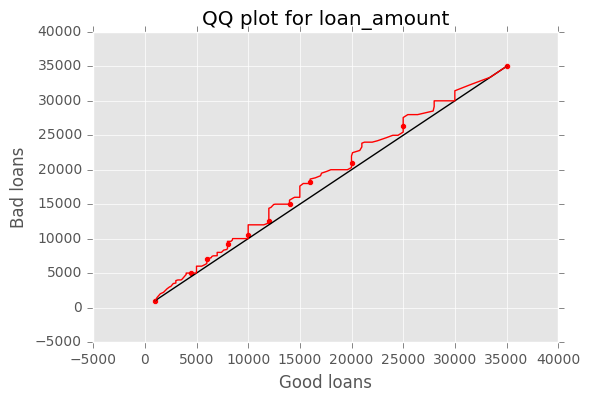

In [425]:
good_bad_quantile_plot(data, 'loan_amount')

In [426]:
# logistic regression
fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.2287
	Testing: 0.2257

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,218,"2,709"
1,Actual_good,29,580


F1 score =  0.297608197343


In [427]:
# random_forests
fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.7121
	Testing: 0.668

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,168",732
1,Actual_good,437,184


F1 score =  0.239816214568


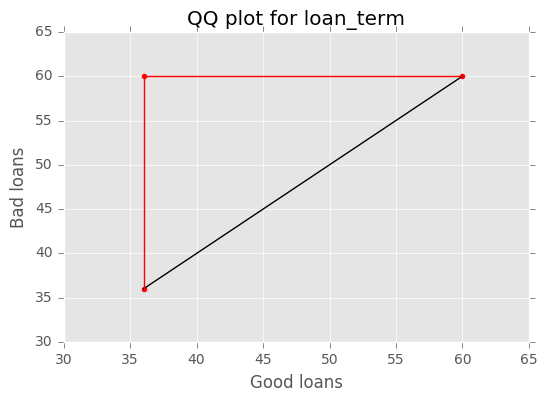

In [428]:
good_bad_quantile_plot(data, 'loan_term')

In [429]:
fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], log_reg)

Accuracy with logistic regression:
	Training: 0.1758
	Testing: 0.1782

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,0,"2,881"
1,Actual_good,0,625


F1 score =  0.302509617161


In [430]:
# random_forests
fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.7269
	Testing: 0.724

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,356",575
1,Actual_good,405,215


F1 score =  0.304874052811


In [431]:
# SVM
# fit_and_score_one_model(data[['loan_term']].values, data['loan_status'], svm)

In [432]:
# random_forests
fit_and_score_one_model(data[['loan_amount', 'dti', 'revol_util', 'rir', 
                             'annual_income', 'loan_term']].values, 
                        data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.974
	Testing: 0.8008

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,749",137
1,Actual_good,562,63


F1 score =  0.15255239734


In [433]:
# SVM
# fit_and_score_one_model(data[['loan_amount']].values, data['loan_status'], svm)

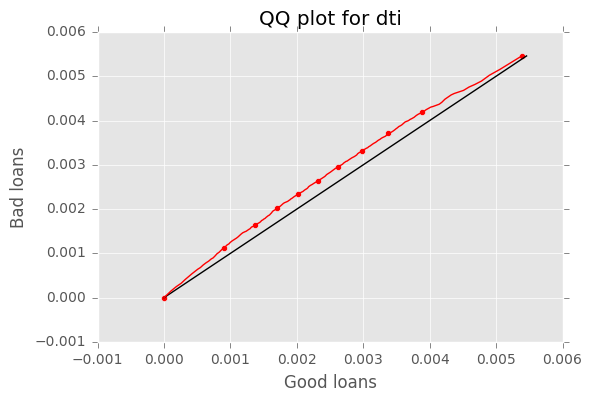

In [434]:
good_bad_quantile_plot(data, 'dti')

In [435]:
# random_forests
fit_and_score_one_model(data[['dti']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.8492
	Testing: 0.6996

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,271",572
1,Actual_good,468,152


F1 score =  0.225885554239


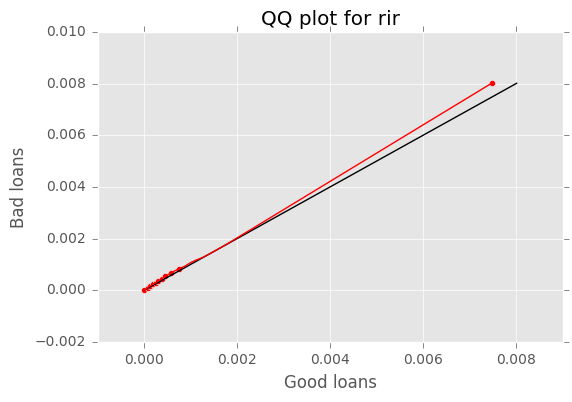

In [436]:
good_bad_quantile_plot(data, 'rir')

In [437]:
# random_forests
fit_and_score_one_model(data[['dti']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.8449
	Testing: 0.6883

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,346",640
1,Actual_good,490,151


F1 score =  0.210291139774


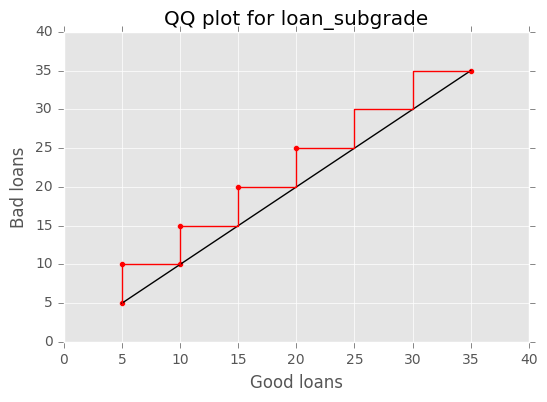

In [438]:
good_bad_quantile_plot(data, 'loan_subgrade')

In [439]:
# random_forests
fit_and_score_one_model(data[['loan_subgrade']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.5454
	Testing: 0.5482

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"1,479","1,433"
1,Actual_good,171,468


F1 score =  0.368541256198


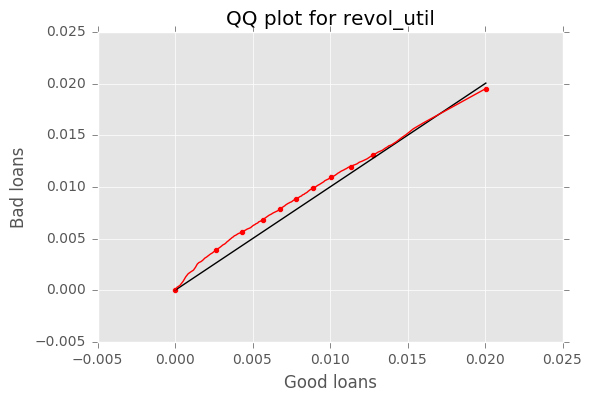

In [440]:
good_bad_quantile_plot(data, 'revol_util')

In [441]:
# random_forests
fit_and_score_one_model(data[['revol_util']].values, data['loan_status'], rf)

Accuracy with random forests:
	Training: 0.8375
	Testing: 0.6835

Confusion Matrix:


,0,Predicted_bad,Predicted_good
0,Actual_bad,"2,273",645
1,Actual_good,477,151


F1 score =  0.212319828341


### Stacking

In [442]:
### extract predictors and response
def extract_predictors_response(x, y):
    mask = np.random.rand(x.shape[0]) < 0.8

    x_train = x[mask, :]
    x_test = x[~mask, :]

    y_train = y.values[mask]
    y_test = y.values[~mask]
    
    return x_train, y_train, x_test, y_test

In [443]:
# function to create model stack
def create_model_stack(x, y):
    model_stack = []

    # logistic regression
    model = get_model_instance(log_reg, y)
    model.fit(x, y)
    model_stack.append(model)

#     # QDA
#     model = get_model_instance(qda, y)
#     model.fit(x, y)
#     model_stack.append(model)

#     # KNN
#     model = get_model_instance(knn, y)
#     model.fit(x, y)
#     model_stack.append(model)

    # random forests
    model = get_model_instance(rf, y)
    model.fit(x, y)
    model_stack.append(model)

    # # boosting
    # model = get_model_instance(boost, y)
    # model.fit(x, y)
    # model_stack.append(model)

#     # SVM
#     model = get_model_instance(svm, y)
#     model.fit(x, y)
#     model_stack.append(model)
    
    return model_stack

In [444]:
# function to fit and score a stacking ensemble
def fit_score_stacking(models, x_train, y_train, x_test, y_test, combiner, combiner_name):
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    num_models = len(models)
    
    # create variables to hold predictions
    y_train_stack = np.zeros((n_train, num_models))
    y_test_stack = np.zeros((n_test, num_models))
    y_predict = np.zeros(n_test)

    # predict with each model on training and testing data
    for index in range(num_models):
        model = models[index]
        y_train_stack[:, index] = model.predict(x_train)
        y_test_stack[:, index] = model.predict(x_test)

    # predict with ensemble
    combiner.fit(y_train_stack, y_train)
    y_predict = combiner.predict(y_test_stack)
    
    # score with ensemble
    score = combiner.score(y_test_stack, y_test)
    cm = confusion_matrix(y_test, y_predict)
    f1_result = f1_score(y_test, y_predict, pos_label = 1)
    
    # format confusion matrix
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)

    return score, cm_df, f1_result

In [445]:
# fit and score a stacked model for given predictors and response
def try_one_stacked_model(x, y, combiner_type, combiner_name):

    x_train, y_train, x_test, y_test = extract_predictors_response(x, y)

    model_stack = create_model_stack(x_train, y_train)

    combiner = get_model_instance(combiner_type, y_train)

    score, cm_df, f1_result = fit_score_stacking(model_stack, x_train, y_train, 
                                                 x_test, y_test, combiner, combiner_name)

    print
    print "Accuracy with stacking by " + combiner_name + " = " + str(round(score, 4))
    print
    print "Confusion Matrix"
    display(cm_df)
    print
    print "F1 score with stacking by " + combiner_name + " = " + str(round(f1_result, 4))

In [446]:
# fit and score a stacked-model ensemble using NLP features
try_one_stacked_model(count_cols_bool, data_nlp['loan_status'], rf, "random forests")


Accuracy with stacking by random forests = 0.6604

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,775,230
1,Actual_good,188,38



F1 score with stacking by random forests = 0.1538


In [447]:
# fit and score a stacked-model ensemble using loan amount
try_one_stacked_model(data['loan_amount'].reshape(-1, 1), data['loan_status'], 
                      rf, "random forests")


Accuracy with stacking by random forests = 0.6872

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,2216,604
1,Actual_good,475,155



F1 score with stacking by random forests = 0.2232


In [448]:
try_one_stacked_model(desc_matrix, data_nlp['loan_status'], rf, "random forests")


Accuracy with stacking by random forests = 0.7405

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,880,136
1,Actual_good,184,33



F1 score with stacking by random forests = 0.171


In [449]:
nlp_base = np.concatenate((count_cols_bool, 
                           data_nlp[['loan_amount', 'annual_income', 'rir',
                                    'revol_util', 'dti', 'loan_term']]), axis = 1)
try_one_stacked_model(nlp_base, data_nlp['loan_status'], log_reg, "logistic regression")


Accuracy with stacking by logistic regression = 0.5142

Confusion Matrix


,0,Predicted_bad,Predicted_good
0,Actual_bad,473,535
1,Actual_good,47,143



F1 score with stacking by logistic regression = 0.3295
